In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression,Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./train.csv", index_col=0)
Y = data['Overall']
X = data.drop(['Overall','Wage','Value'],axis=1)

X.shape, Y.shape

((17904, 725), (17904,))

PART 1.特征选择
=

1.划分数据集 + 标准化
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 725), (3581, 725), (2865, 725), (11458,), (3581,), (2865,))

2.特征选择
=

In [4]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

impt = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
print(len(impt))
impt.sort_values("Feature Importance", ascending=False).round(5).head(10)

725


,Feature Importance
Special,10.69896
Potential,3.23172
Age,2.95469
PositionBehave,2.50158
Behavior2,1.81905
Weight,1.64963
Physical,1.57662
Reactions,1.55751
BallControl,1.46865
Composure,1.18960


(194, 1)

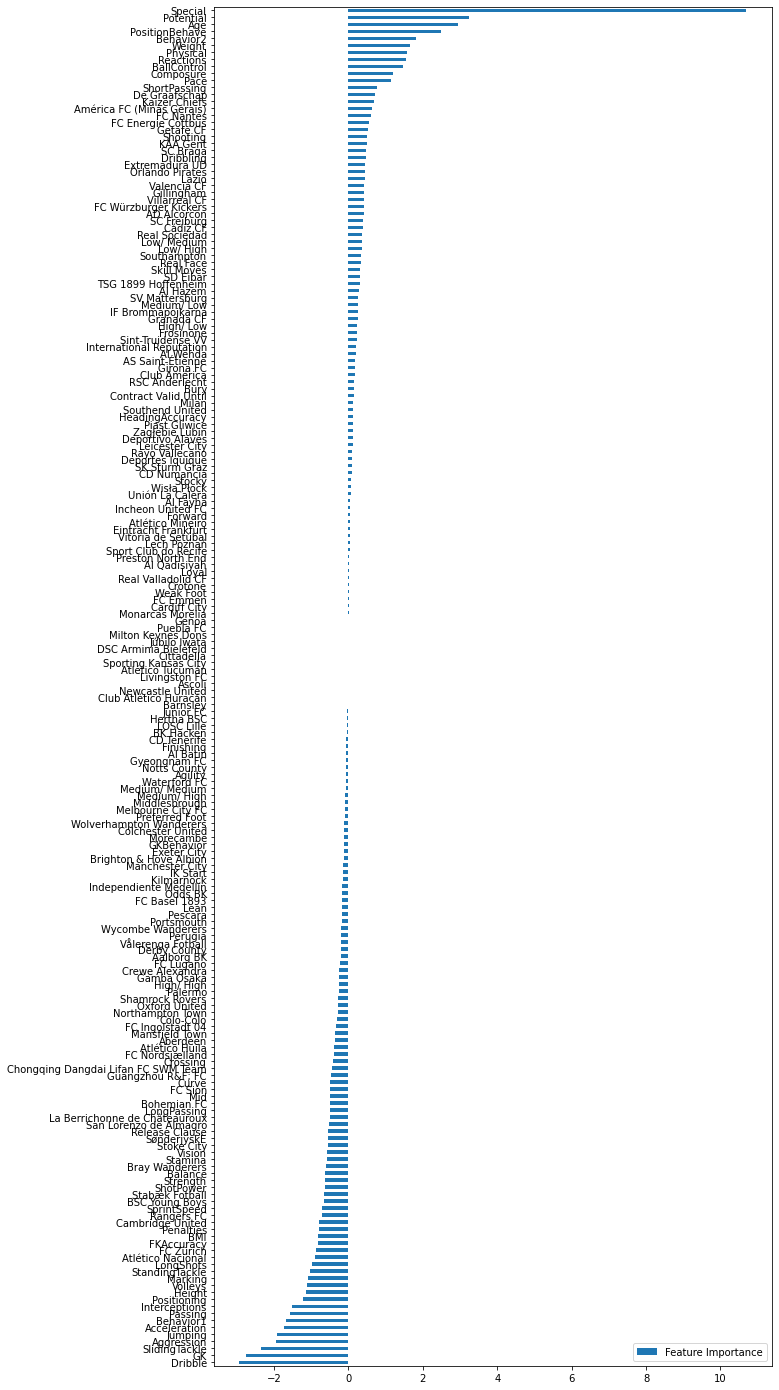

In [5]:
impt = impt[impt["Feature Importance"] != 0].sort_values("Feature Importance")
impt.plot(kind="barh", figsize=(10, 25))
display(impt.shape)

In [6]:
chooseFeatures = impt.index.to_list()
chooseData = X[chooseFeatures].copy()
chooseData.shape

(17904, 194)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(chooseData, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 194), (3581, 194), (2865, 194), (11458,), (3581,), (2865,))

3.建模
=

LinearRegression
=

In [8]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 2.6426401658731824
测试集MSE = 2.7293140511664347

训练集MAPE = 0.019763367331282766
测试集MAPE = 0.019976417194861006

训练集R2_Score = 0.9477497051662119
测试集R2_Score = 0.9424320438918363


RandomForest
=

In [9]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 0.1285762666666667
测试集MSE = 0.7645464116168668

训练集MAPE = 0.003415061576061832
测试集MAPE = 0.008764916751029922

训练集R2_Score = 0.9974577893998893
测试集R2_Score = 0.9838738329699348


In [10]:
rfc_params = {
    'n_estimators':[300,400,500,600,700]
}

clf = GridSearchCV(rfc,param_grid=rfc_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

rfc = RandomForestRegressor(**clf.best_params_)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

{'n_estimators': 600}

训练集MSE = 0.12524215925925927
测试集MSE = 0.7243886049830895

训练集MAPE = 0.003325577188811359
测试集MAPE = 0.008639672635943485

训练集R2_Score = 0.9975237113885483
测试集R2_Score = 0.984720860027413


XGB
=

In [11]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 0.21090995704616944
测试集MSE = 0.7791349872372441

训练集MAPE = 0.005420624478255883
测试集MAPE = 0.010367157329224046

训练集R2_Score = 0.9958298872539074
测试集R2_Score = 0.9835661239759348


In [12]:
xgb_params = {
    'n_estimators':[300,400,500,600,700],
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 500}

训练集MSE = 0.004604893641827705
测试集MSE = 0.7432652055939427

训练集MAPE = 0.0007249590017308824
测试集MAPE = 0.010103303024452205

训练集R2_Score = 0.9999089520194346
测试集R2_Score = 0.9843227060242221


LGBM
=

In [13]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 0.40336697109465536
测试集MSE = 0.6364785965179881

训练集MAPE = 0.0073326038922248956
测试集MAPE = 0.009101513223690379

训练集R2_Score = 0.9920246261908519
测试集R2_Score = 0.9865750986433848


In [15]:
lgbm_params = {
    'n_estimators':[300,400,500,600,700],
    'learning_rate':[0.01,0.05,0.1]
    
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 600}

训练集MSE = 0.05611755849190034
测试集MSE = 0.5500579266107192

训练集MAPE = 0.002728367595374221
测试集MAPE = 0.008467193010915324

训练集R2_Score = 0.9988904433473691
测试集R2_Score = 0.9883979234406753


Result
=

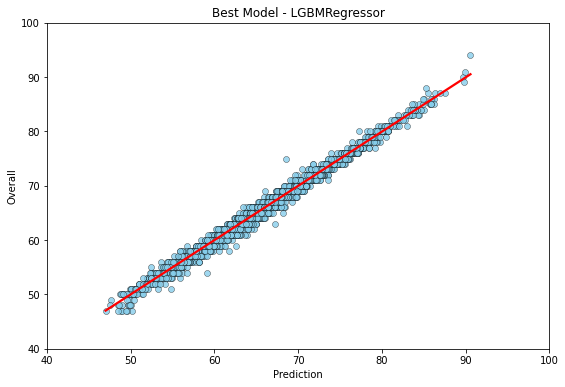

In [19]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_lgbm,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - LGBMRegressor")
plt.xlim(40,100)
plt.ylim(40,100)
plt.show()

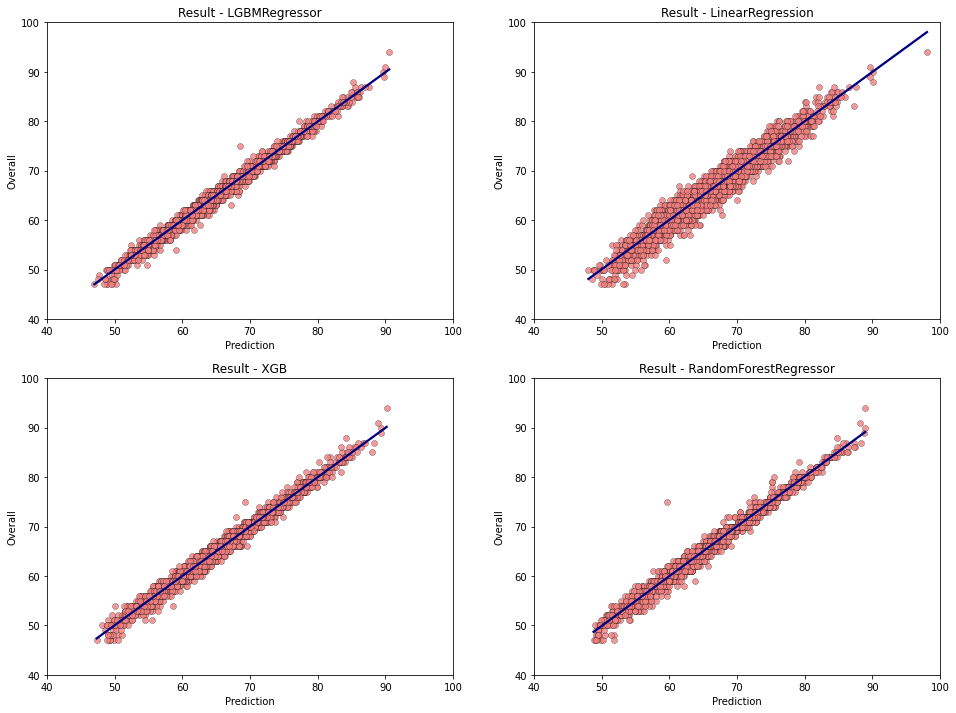

In [22]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(40,100)
    ax[r,c].set_ylim(40,100)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()

PART 2.PCA
=

1.划分数据集
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 725), (3581, 725), (2865, 725), (11458,), (3581,), (2865,))

2.降维
=

In [4]:
pca = PCA(n_components=190)
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

0.9800513656364733
190


In [5]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((11458, 190), (3581, 190), (2865, 190))

3.建模
=

LinearRegression
=

In [6]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 3.027963162924661
测试集MSE = 2.980700830606486

训练集MAPE = 0.021070022316632568
测试集MAPE = 0.020871769609938154

训练集R2_Score = 0.9401310969038471
测试集R2_Score = 0.9371296775046509


RandomForest
=

In [7]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 0.6284811666666665
测试集MSE = 4.023388131806757

训练集MAPE = 0.009097091445930088
测试集MAPE = 0.023854635872859957

训练集R2_Score = 0.9875736671682026
测试集R2_Score = 0.9151368340045108


In [9]:
rfc = RandomForestRegressor(n_estimators=600)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 0.6043762027777777
测试集MSE = 3.9380831037264574

训练集MAPE = 0.008965324013813128
测试集MAPE = 0.023554130968153505

训练集R2_Score = 0.9880502706371187
测试集R2_Score = 0.9169361271676533


XGB
=

In [10]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 0.3238686937201031
测试集MSE = 2.6062889846344266

训练集MAPE = 0.006659946004065165
测试集MAPE = 0.01926057001570104

训练集R2_Score = 0.9935964665364428
测试集R2_Score = 0.9450269455768555


In [11]:
xgb_params = {
    'n_estimators':[150,200,300,400]
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 300}

训练集MSE = 0.023161362432535193
测试集MSE = 2.530043467345121

训练集MAPE = 0.0017132153518795556
测试集MAPE = 0.01896170275704211

训练集R2_Score = 0.9995420534238901
测试集R2_Score = 0.9466351513422856


LGBM
=

In [12]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 1.0739030762804145
测试集MSE = 2.3027240727012313

训练集MAPE = 0.01241290497649985
测试集MAPE = 0.01790772475261867

训练集R2_Score = 0.9787667829002277
测试集R2_Score = 0.9514298773020193


In [14]:
lgbm_params = {
    'n_estimators':[150,200,300,400],
    'learning_rate':[0.01,0.05,0.1]
    
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 300}

训练集MSE = 0.28037834915600685
测试集MSE = 1.9837404919557313

训练集MAPE = 0.006388019429430328
测试集MAPE = 0.016570456821397916

训练集R2_Score = 0.9944563578509102
测试集R2_Score = 0.9581580267312628


Result
=

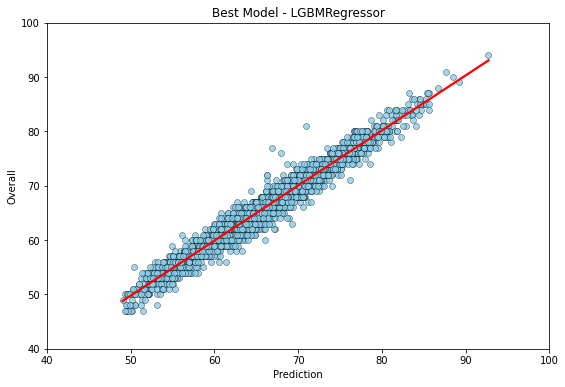

In [15]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_lgbm,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - LGBMRegressor")
plt.xlim(40,100)
plt.ylim(40,100)
plt.show()

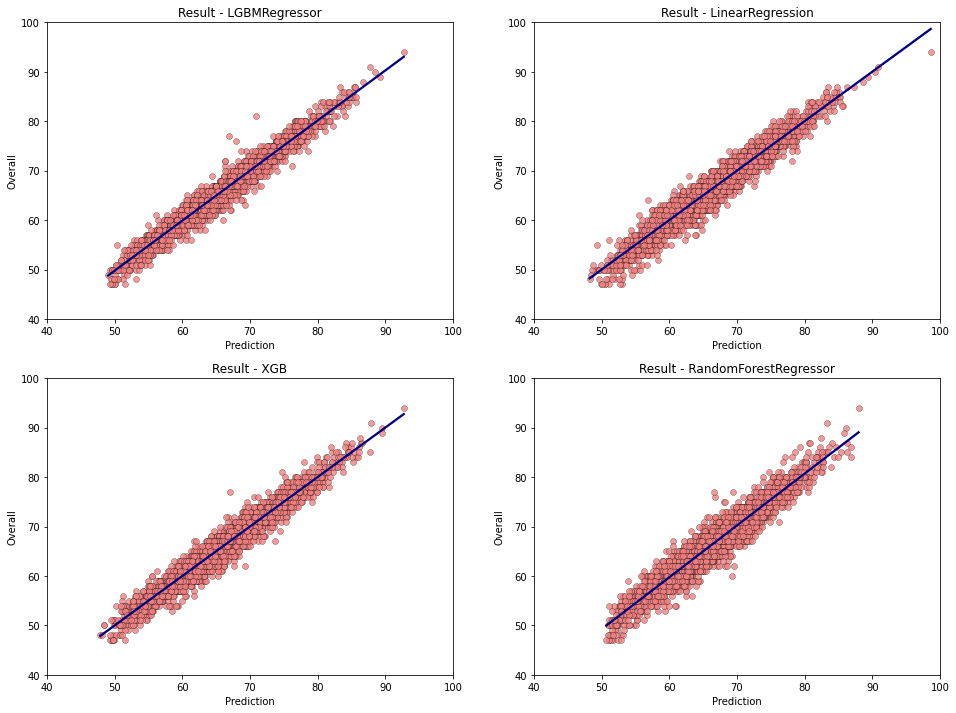

In [16]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(40,100)
    ax[r,c].set_ylim(40,100)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()

PART 3.特征选择 + PCA
=

1.划分数据集
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 725), (3581, 725), (2865, 725), (11458,), (3581,), (2865,))

2.特征选择
=

In [4]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

impt = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
impt.sort_values("Feature Importance", ascending=False).round(5).head(10)

,Feature Importance
Special,10.69896
Potential,3.23172
Age,2.95469
PositionBehave,2.50158
Behavior2,1.81905
Weight,1.64963
Physical,1.57662
Reactions,1.55751
BallControl,1.46865
Composure,1.18960


(194, 1)

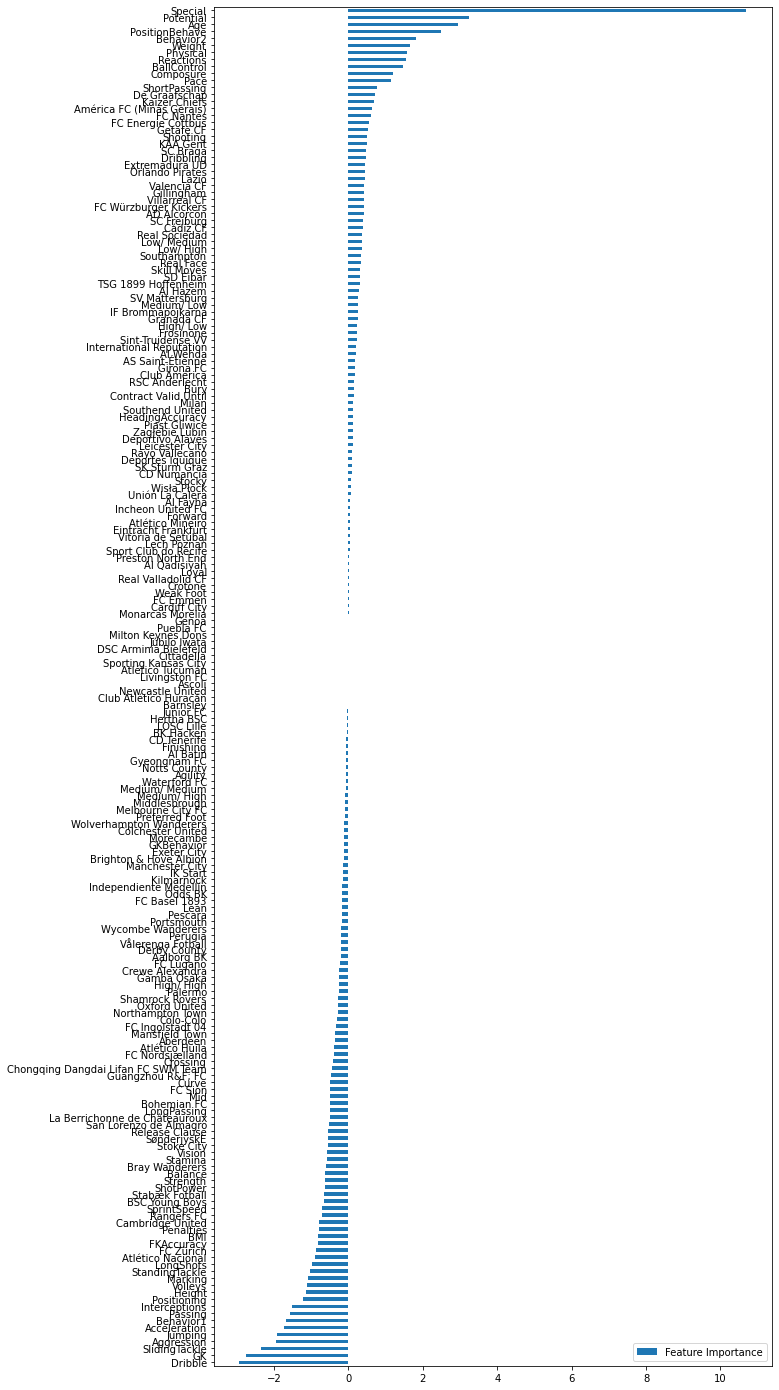

In [5]:
impt = impt[impt["Feature Importance"] != 0].sort_values("Feature Importance")
impt.plot(kind="barh", figsize=(10, 25))
display(impt.shape)

In [6]:
chooseFeatures = impt.index.to_list()
chooseData = X[chooseFeatures].copy()
chooseData.shape

(17904, 194)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(chooseData, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 194), (3581, 194), (2865, 194), (11458,), (3581,), (2865,))

3.PCA
=

In [8]:
pca = PCA(n_components='mle')
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

1.0000000000000002
191


In [9]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((11458, 191), (3581, 191), (2865, 191))

4.建模
=

LinearRegressor
=

In [10]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 2.6286741958732933
测试集MSE = 2.7274198738320714

训练集MAPE = 0.019718993627323347
测试集MAPE = 0.019977533845706327

训练集R2_Score = 0.9480258403962587
测试集R2_Score = 0.9424719967575019


RandomForest
=

In [11]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 0.5493269666666667
测试集MSE = 3.749185730242949

训练集MAPE = 0.008599872642608784
测试集MAPE = 0.022839955849031483

训练集R2_Score = 0.9891387044141896
测试集R2_Score = 0.9209204380610804


In [13]:
rfc = RandomForestRegressor(n_estimators=500)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

{'n_estimators': 400}

训练集MSE = 0.5168052960000001
测试集MSE = 3.6421147746439546

训练集MAPE = 0.008366389487808509
测试集MAPE = 0.022510155061674576

训练集R2_Score = 0.9897817230524305
测试集R2_Score = 0.9231788282488081


XGB
=

In [14]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 0.28284209693729645
测试集MSE = 2.4359007556614913

训练集MAPE = 0.0061837433907909085
测试集MAPE = 0.018555912301462293

训练集R2_Score = 0.9944076446172165
测试集R2_Score = 0.9486208530213541


In [15]:
xgb_params = {
    'n_estimators':[200,300,400,500]
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 300}

训练集MSE = 0.010564213116881244
测试集MSE = 2.397174555094441

训练集MAPE = 0.001134111837073711
测试集MAPE = 0.018448789638392908

训练集R2_Score = 0.9997911243243888
测试集R2_Score = 0.9494376839805936


LGBM
=

In [16]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 0.9707149104819757
测试集MSE = 2.0658252759188924

训练集MAPE = 0.011883513598699394
测试集MAPE = 0.016852740295726348

训练集R2_Score = 0.9808070198405243
测试集R2_Score = 0.956426656448565


In [17]:
lgbm_params = {
    'n_estimators':[200,300,400,500]
    
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 600}

训练集MSE = 0.05514225229077231
测试集MSE = 1.7475245828134445

训练集MAPE = 0.002731603116759881
测试集MAPE = 0.015486091819471779

训练集R2_Score = 0.9989097271065507
测试集R2_Score = 0.9631404020954103


Result
=

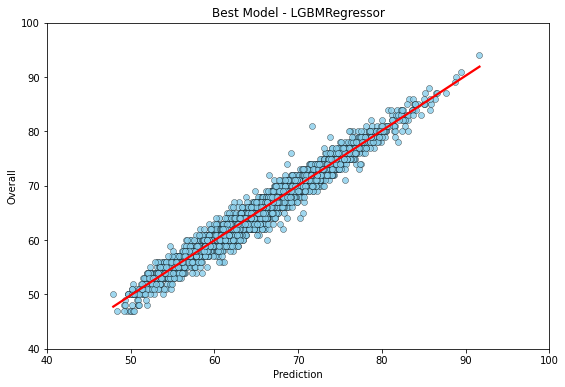

In [18]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_lgbm,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - LGBMRegressor")
plt.xlim(40,100)
plt.ylim(40,100)
plt.show()

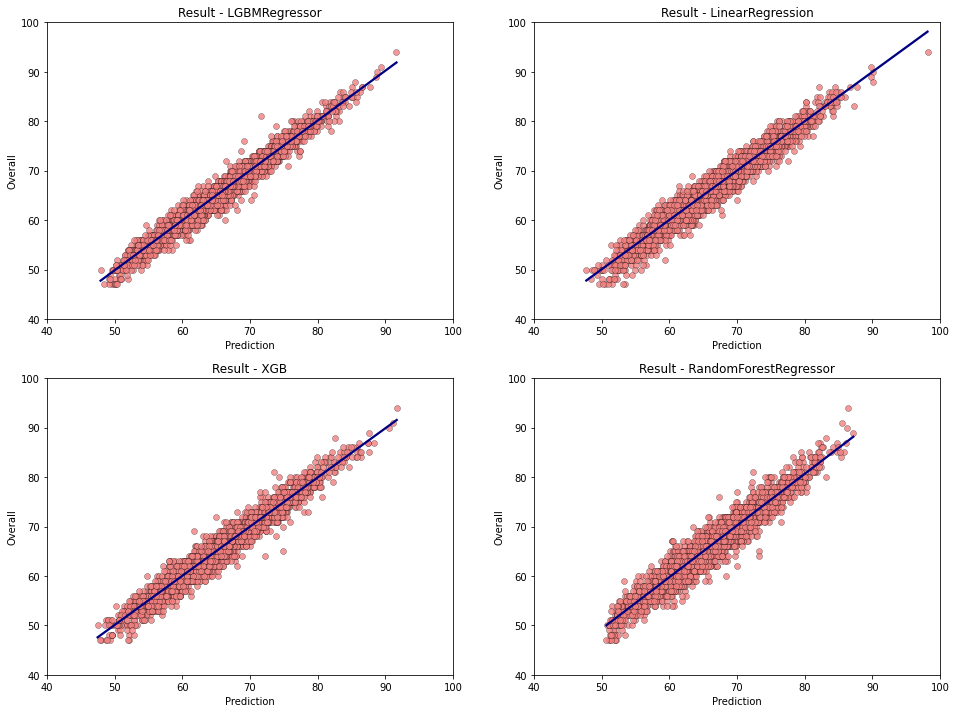

In [19]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(40,100)
    ax[r,c].set_ylim(40,100)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()